# [量子位相推定](../ch-algorithms/quantum-phase-estimation.html)を使った円周率($\pi$)の推定

### 1.[量子位相推定アルゴリズム](../ch-algorithms/quantum-phase-estimation.html)の概要

量子推定アルゴリズム（QPE）は多くの非常に複雑な量子アルゴリズムの一角を担う量子アルゴリズムの１つです。その中心にあるのは、QPEはかなり簡単な問題を解きます。$U\vert\psi\rangle = \exp\left(2 \pi i  \theta\right)\vert\psi\rangle$）となっている演算子$U$の量子状態$\vert\psi\rangle$が与えられているとき、$\theta$の推定値を得ることができますか？

この答えは”yes"です。QPEアルゴリズムから$2^n\theta$を得られます。ここで$n$とは$\theta$を推定するために使っている量子ビット数です。


### 2.円周率$\pi$の推定

このデモでは、演算子と状態を次のように選びます。

$$U =  u_1(\theta), \vert\psi\rangle = \vert1\rangle$$

ここで

$$
u_1(\theta) = \begin{bmatrix}
1 & 0\\ 0 & \exp(i\theta)
\end{bmatrix}
$$

この行列はQiskitで利用可能な量子ゲートの１つで、そして以下を満たします。

$$u_1(\theta)\vert1\rangle = \exp(i\theta)\vert1\rangle.$$ 

$\theta =  1$となるようにゲートの位相を選ぶと、次の関係性を利用して$\pi$を推定することができます。

1. QPEアルゴリズムの結果から、$2^n\theta$の推定値を測定します。そのとき、 $\theta = \text{measured} / 2^n$ となります。
2. 上記の$u_1(\theta)$ゲートの定義から、$2\pi\theta = 1 \Rightarrow \pi = 1 / 2\theta$であることを知ることができます。

これらの関係性を使って、 $\pi = 1 / \left(2 \times (\text{(measured)}/2^n)\right)$であることがわかります。

QPEのより詳細な解説には、Qiskit Textbook中の専用の章を参照してください。 
[qiskit.org/textbook](../ch-algorithms/quantum-phase-estimation.html).

## 3. コードを書いてみよう！

まずは、次の必要なライブラリをインポートすることから始めていきましょう。

In [1]:
## 作業に必要になるライブラリのインポート
from IPython.display import clear_output
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plotter
from qiskit.tools.monitor import job_monitor
# 可視化の設定
import seaborn as sns, operator
sns.set_style("dark")

pi = np.pi

関数`qft_dagger`は、逆量子フーリエ変換を計算します。このアルゴリズムのより詳細な解説は、[Qiskit Textbook](../ch-algorithms/quantum-fourier-transform.html)の以下の章を参照してください。

In [2]:
## 逆量子フーリエ変換のコード
## Qiskit Textbook qiskit.org/textbookから抜粋

def qft_dagger(circ_, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(qubit, n_qubits-qubit-1)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), m, j)
        circ_.h(j)

次の関数`qpe_pre`は、推定値に対する初期状態を準備します。開始時の状態は、最後の量子ビット以外の全ての量子ビットにアダマールゲートを適用し、最後の量子ビットには$\vert1\rangle$をセットすることで生成されていることに注意してください。

In [3]:
## 量子位相推定の初期状態のコード
## Qiskit textbook　qiskit.org/textbookから抜粋
## 開始時の状態には最後の量子ビット以外にHを適用し、最後の量子ビットには|psi> = |1>にセットすることに注意

def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

次に、回路を実行し結果を返すための簡単な関数`run_job`を書きましょう。

In [4]:
## 実機かシミュレーターでQiskitジョブの実行

def run_job(circ, backend, shots=1000, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level)
    qobj = assemble(t_circ, shots=shots)
    job = backend.run(qobj)
    job_monitor(job)
    return job.result().get_counts()

その次に、クラウドのシミュレーターか実デバイスを使うためにご自身のアカウントを読み込みます。

In [ ]:
## クラウド上のシミュレーターか実量子デバイスを使いたい場合は、ご自身のIBMQアカウントを読み込む
my_provider = IBMQ.load_account()
simulator_cloud = my_provider.get_backend('ibmq_qasm_simulator')
device = my_provider.get_backend('ibmq_16_melbourne')

In [5]:
simulator = Aer.get_backend('aer_simulator')

最後に、上記の関数を$\pi$の推定値を得るために`n_qubits`を使うように`get_pi_estimate`と呼ばれる関数にまとめます。

In [6]:
## 円周率を推定するための関数
## サマリ：Qiskit textbook(qiskit.org/textbook)の記法を用いて、
## u1(theta)|1> = exp(2 x pi x i x theta)|1>であるような
## 演算子U = u1(theta) and |psi> = |1>の量子位相推定を実行する。
## thetaを1ラジアンにセットすることで 2^n x 1 ラジアン = 最も頻繁したカウント = 2 x piを用いることで円周率を求める

def get_pi_estimate(n_qubits):

    # 量子回路の生成
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    # 入力状態の生成
    qpe_pre(circ, n_qubits)
    # バリアの適用
    circ.barrier()
    # 逆フーリエ変換の実行
    qft_dagger(circ, n_qubits)
    # バリアの適用
    circ.barrier()
    # 最終量子ビット以外の測定
    circ.measure(range(n_qubits), range(n_qubits))

    # ジョブの実行と結果の取得
    counts = run_job(circ, backend=simulator, shots=10000, optimization_level=0)
    # print(counts) 

    # 最も多く発生した結果の取得
    max_counts_result = max(counts, key=counts.get)
    max_counts_result = int(max_counts_result, 2)
    
    # 測定値から円周率を推定する
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

ここでは、異なる量子ビット数で`get_pi_estimate`関数を実行し、推定値を表示しています。

In [7]:
# 異なる量子ビット数で円周率を推定
nqs = list(range(2,12+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

Job Status: job has successfully run
2 qubits, pi ≈ 2.0
Job Status: job has successfully run
3 qubits, pi ≈ 4.0
Job Status: job has successfully run
4 qubits, pi ≈ 2.6666666666666665
Job Status: job has successfully run
5 qubits, pi ≈ 3.2
Job Status: job has successfully run
6 qubits, pi ≈ 3.2
Job Status: job has successfully run
7 qubits, pi ≈ 3.2
Job Status: job has successfully run
8 qubits, pi ≈ 3.1219512195121952
Job Status: job has successfully run
9 qubits, pi ≈ 3.1604938271604937
Job Status: job has successfully run
10 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
11 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
12 qubits, pi ≈ 3.1411042944785277


そして、全ての結果をプロットします。

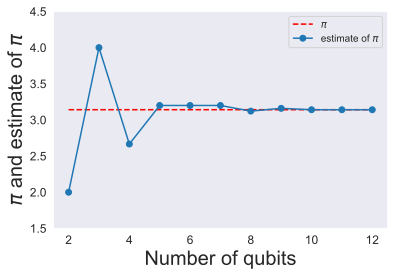

In [8]:
plotter.plot(nqs, [pi]*len(nqs), '--r')
plotter.plot(nqs, pi_estimates, '.-', markersize=12)
plotter.xlim([1.5, 12.5])
plotter.ylim([1.5, 4.5])
plotter.legend(['$\pi$', 'estimate of $\pi$'])
plotter.xlabel('Number of qubits', fontdict={'size':20})
plotter.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plotter.tick_params(axis='x', labelsize=12)
plotter.tick_params(axis='y', labelsize=12)
plotter.show()

In [9]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}